In [1]:
import jax 
import optax

import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

from jax.random import PRNGKey, split

from weight_uncertainty.interface import meanfield_vi

Generate linear data

In [2]:
key = PRNGKey(1)
n = 25

key, subkey = split(key)
f = lambda x: 2 * x + jax.random.normal(subkey, shape=(n, 1)) * 0.1

key, subkey = split(key)
x = jax.random.uniform(subkey, shape=(n, 1),)
y = f(x)

2023-12-06 01:59:43.131390: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


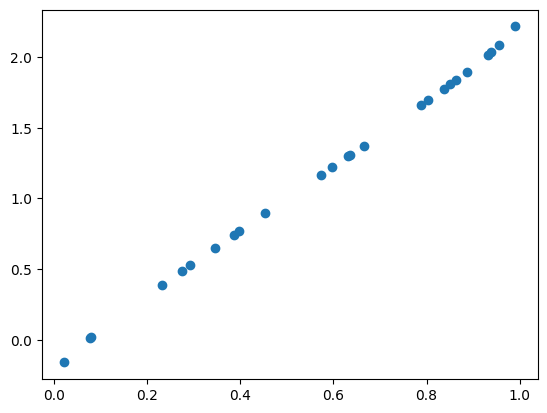

In [3]:
plt.scatter(x, y)

In [4]:
def loglikelihood(params, batch):
    x,y = batch
    slope, intercept = params["slope"], params["intercept"]
    out = slope @ x + intercept
    return - jnp.mean((out - y) ** 2)


def data_stream(seed, data, batch_size, data_size):
    """Return an iterator over batches of data."""
    rng = np.random.RandomState(seed)
    num_batches = int(jnp.ceil(data_size / batch_size))
    while True:
        perm = rng.permutation(data_size)
        for i in range(num_batches):
            batch_idx = perm[i * batch_size : (i + 1) * batch_size]
            yield data[batch_idx]

def compute_predictions(params, x):
    slope, intercept = params["slope"], params["intercept"]
    out = slope @ x + intercept
    return out
compute_predictions = jax.vmap(compute_predictions, in_axes=[None, 0])

In [6]:
optimizer = optax.adam(5e-4)
mfvi = meanfield_vi(loglikelihood,optimizer, 30, logprior_name="unit_gaussian")

pos = {"slope": jnp.array([0.0]), "intercept": jnp.array([0.0])}
mfvi_state = mfvi.init(pos)


In [7]:
for i in range(50_000):
    batch = (x, y)
    mfvi_state, mfvi_info, key = mfvi.step(key, mfvi_state, batch)

    if i % 25 == 0:
        print(
            f"Elbo at step {i} | {mfvi_info.elbo} | Log variational: {mfvi_info.log_variational} | Log joint: {mfvi_info.log_joint}"
        )

TypeError: dot_general requires contracting dimensions to have the same shape, got (1,) and (25,).

In [199]:
params, key = mfvi.sample(key, mfvi_state, 25)

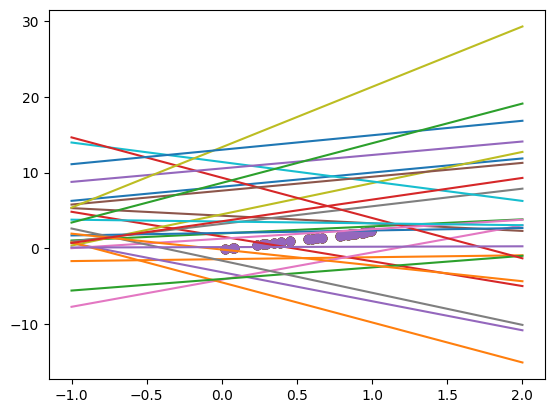

In [200]:
x_ = jnp.linspace(-1, 2).reshape(-1, 1)
lines = []
slopes, intercepts = params.values()
for slope, intercept in zip(slopes, intercepts):
    pred = compute_predictions({"slope": slope, "intercept": intercept}, x_)
    lines.append(pred)

for line in lines:
    
    plt.plot(x_, line.squeeze())
    plt.scatter(x, y)

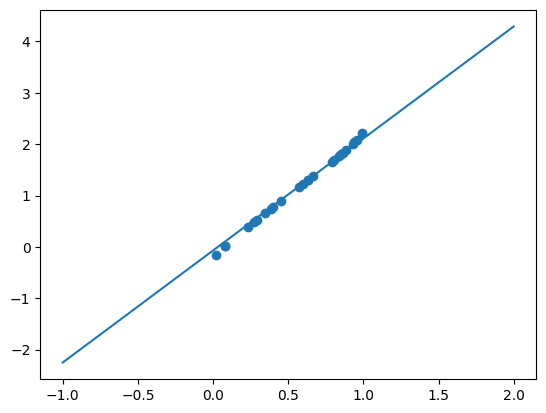

In [201]:
mean_pred = compute_predictions(mfvi_state.mu, x_)
plt.plot(x_, mean_pred)
plt.scatter(x, y)